In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import librosa

## EDA

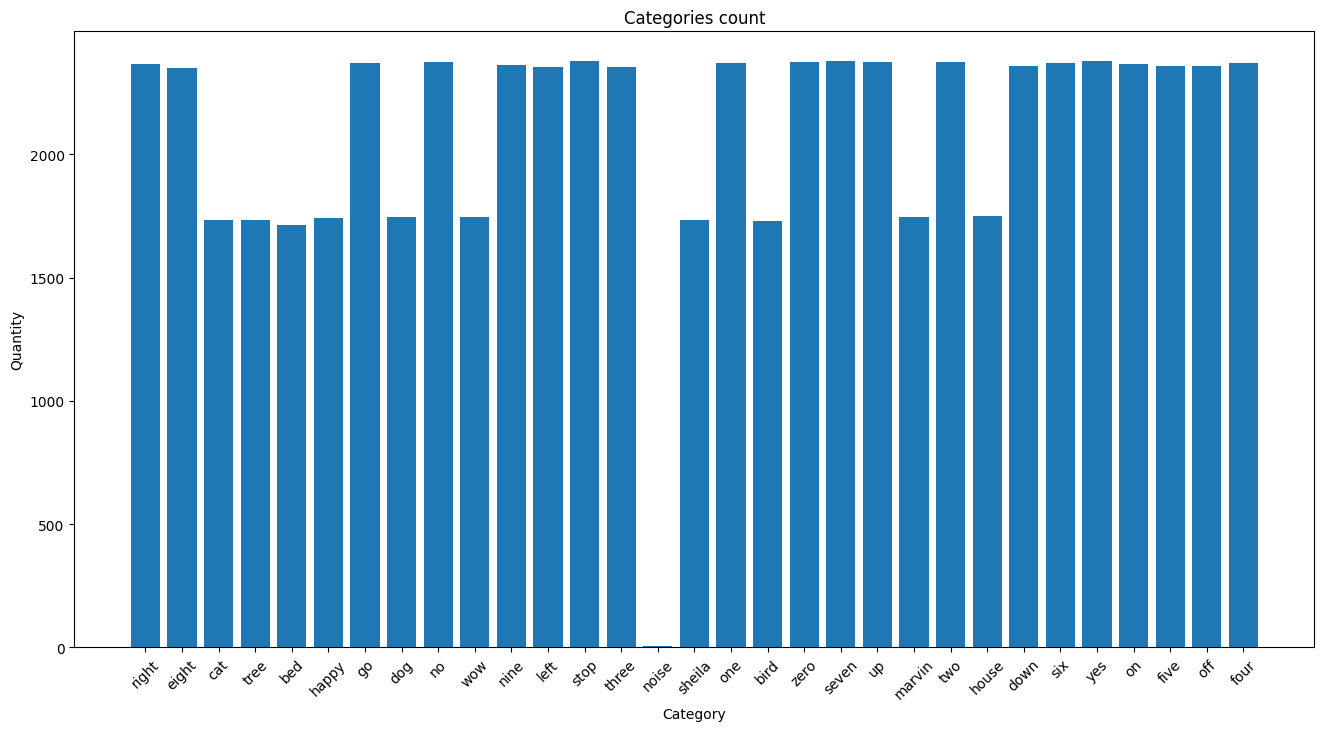

In [3]:
train_path = 'audio_data/train/audio'
categories = [category for category in os.listdir(train_path) if category[0] != '.']
categories_count = [len(os.listdir('{train_path}/{category}'.format(train_path=train_path, category=category))) 
                     for category in categories]
categories = [(category if category != '_background_noise_' else 'noise') for category in categories]

plt.figure(figsize=(16, 8))

plt.bar(categories, categories_count)

plt.title('Categories count')
plt.xlabel('Category')
plt.ylabel('Quantity')

plt.xticks(rotation=45)


plt.show()

In [ ]:
print('All train data:', sum(categories_count))
print('All test data:', len(os.listdir('audio_data/test/audio')))
print('Number of classes', len(categories))

# test data doesnt have labels, so train data is used for training, testing and validation according to testing_list.txt, validation_list.txt

All train data: 64728
All test data: 158538
Number of classes 31


There are 30 classes, each containing around 2k examples


In [5]:
# Checking example
example_no = 2
category = 'dog'
audio_filename = os.listdir('{working_directory}/{train_path}/{category}'.format(working_directory = os.getcwd(),
                                                                          train_path=train_path, 
                                                                          category=category))[example_no]

full_file_path = '{working_directory}/{train_path}/{category}/{filename}'.format(working_directory = os.getcwd(),
                                                                          train_path=train_path, 
                                                                          category=category,
                                                                          filename = audio_filename)


ipd.Audio(full_file_path)

In [ ]:
# Sampling rate check <- number of samples taken per second from a continuous signal

y, sr = librosa.load(full_file_path, sr=None)  # sr=None to preserve original sampling rate
print("Sampling rate:", sr)
print('Number of elements in an array of a sound:', len(y)) # -> 1 second recordings

Sampling rate: 16000
Number of elements in an array of a sound: 16000
